In [1]:
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from utils import od_dataloader,masked_mse, ODLoss,set_seed
from config import get_configs
import numpy as np
import pandas as pd
from models import VSTA,ContrastiveLoss,BSTA,ODTA,Model
# from mssta_model import MSSTA
from lib import train, test

In [2]:
args = get_configs()

In [3]:
train_dataloader,val_dataloader, test_dataloader = od_dataloader(args)

train number:832
validation number:128
test number:128


In [4]:
se = torch.Tensor(np.load(args.se_path)).to(args.device)
pe = torch.Tensor(pd.read_csv(args.pe_path,index_col=0).values).to(args.device)

In [5]:
args.model_name = 'dlsta-v4'
# args.batch_size = 32

In [6]:
model = Model(args.num_nodes,
        args.in_seq_len,
        args.out_seq_len,
        args.s_feature,
        args.p_feature,
        args.t_feature,
        args.hidden_channels,
        args.attention_window,
        args.d_model,
        args.heads,
        args.num_encoder_layers)

In [7]:
# model = BSTA(args.num_nodes,
#         args.in_seq_len,
#         args.out_seq_len,
#         args.d_model,
#         args.heads,
#         args.num_encoder_layers)

In [8]:
# seeds = [42, 3407, 114514]
seeds = [42]

In [9]:
mse_total = rmse_total = mae_total = mape_total = 0
mse_list = []
rmse_list = []
mae_list = []
mape_list = []
for seed in seeds:
    args.seed = seed
    set_seed(args.seed)
    criterion = ODLoss
    contrastive_loss = ContrastiveLoss(margin=5)
    print(f"{args.model_path}/model_{args.model_name}_seed_{args.seed}__epoch_{args.epoch}_batchsize_{args.batch_size}_lr_{args.lr}_layer_{args.num_encoder_layers}_window_{args.attention_window}.pth")
    model.load_state_dict(torch.load(f"../model/model_{args.model_name}_seed_{seed}__epoch_300_batchsize_{args.batch_size}_lr_{args.lr}_layer_{args.num_encoder_layers}_window_{args.attention_window}.pth"))
    mse,rmse,mae,mape,p_total,y_total = test(model,test_dataloader,se,pe,criterion,contrastive_loss,args,True)
    mse_list.append(mse)
    rmse_list.append(rmse)
    mae_list.append(mae)
    mape_list.append(mape)
r_dict = {
    'mse': mse_list,
    'rmse': rmse_list,
    'mae': mae_list,
    'mape': mape_list
}
result = pd.DataFrame(r_dict).round(4)

../model/model_dlsta-v4_seed_42__epoch_300_batchsize_16_lr_0.001_layer_1_window_7.pth


In [10]:
result.describe().round(4)

,mse,rmse,mae,mape
count,1.0000,1.0000,1.0000,1.0000
mean,1.2717,1.1277,0.5242,1.6684
std,NaN,NaN,NaN,NaN
min,1.2717,1.1277,0.5242,1.6684
25%,1.2717,1.1277,0.5242,1.6684
50%,1.2717,1.1277,0.5242,1.6684
75%,1.2717,1.1277,0.5242,1.6684
max,1.2717,1.1277,0.5242,1.6684


In [11]:
# model = MSSTA(args.num_nodes,args.n_feature,
#         args.in_seq_len,
#         args.out_seq_len,
#         args.s_feature,
#         args.p_feature,
#         args.t_feature,
#         args.hidden_channels,
#         args.d_model,
#         args.heads,
#         args.num_encoder_layers).to(args.device)

In [12]:
p_total[0][0][13]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.2688, 0.0089, 0.4324, 0.1508, 0.1041,
        0.0000, 0.4774, 0.1843, 1.4775, 1.7551, 0.0000, 0.0000, 0.0000, 0.0000,
        0.1574, 0.0000, 0.0000, 0.0000, 0.0876, 0.0000, 0.0000, 0.0000, 0.1396,
        0.8541, 0.1288, 0.0249, 0.0000, 0.0108, 0.0707, 0.0000, 0.0028, 0.0000,
        0.0000, 0.9134, 0.2238, 0.1412, 0.1201, 0.4563, 0.2048, 0.1065, 0.0000,
        0.0000, 0.0052, 0.0000, 0.0000, 0.0000, 0.2153, 0.0000, 0.0332, 0.0000,
        0.0000, 0.1133, 0.5354, 0.0000, 0.3951, 0.2495, 0.1661, 0.1424, 0.2096,
        0.0000, 0.0147, 0.0000], device='cuda:0')

In [13]:
y_total[0][0][13]

tensor([0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 2., 2., 1., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')

In [14]:
p_total.shape

torch.Size([128, 24, 66, 66])

In [15]:
p_copy = p_total.permute(2,3,0,1)
p_copy = p_copy.reshape(66*66,128,24)

In [16]:
y_copy = y_total.permute(2,3,0,1)
y_copy = y_copy.reshape(66*66,128,24)

In [17]:
y_1 = y_copy[342]

In [18]:
y_1 = y_1.reshape(128*24)

In [19]:
y_1.shape

torch.Size([3072])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


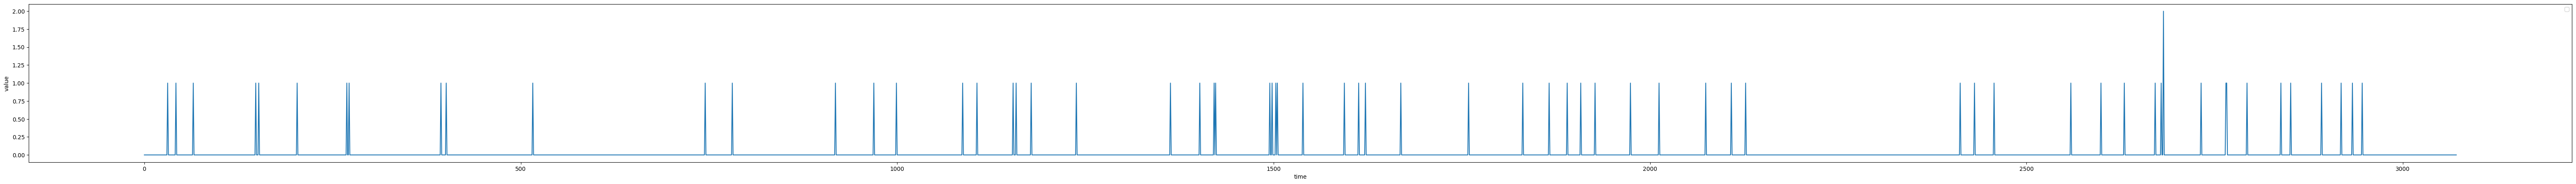

In [20]:
# -*- coding: UTF-8 -*-
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

x = range(128*24)
plt.figure(figsize=(80, 5))
plt.plot(x,y_1.cpu().numpy())
plt.legend()

plt.xlabel('time')
plt.ylabel('value')
plt.show()

In [21]:
p_1 = p_copy[0]

In [22]:
# # -*- coding: UTF-8 -*-
# import numpy as np
# import matplotlib as mpl
# import matplotlib.pyplot as plt

# plt.figure(figsize=(80, 5))
# for i in range(y_1.size(0)):
#     plt.plot(range(y_1.size(0)), y_1[i].cpu(),label=i)
# plt.legend()

# plt.xlabel('time')
# plt.ylabel('value')
# plt.show()

In [23]:
# # -*- coding: UTF-8 -*-
# import numpy as np
# import matplotlib as mpl
# import matplotlib.pyplot as plt

# plt.figure(figsize=(80, 5))
# for i in range(p_1.size(0)):
#     plt.plot(range(0,24), p_1[i].cpu(),label=i)
# plt.legend()

# plt.xlabel('time')
# plt.ylabel('value')
# plt.show()

In [24]:
# p_0 = torch.zeros(1,24,66,66).to(args.device)
# p_total = torch.cat((p_total,p_0),dim=0)
p = p_total.reshape(128*24,66,66)
# p  = p_total.permute(1,0,2,3)
p_time = torch.mean(p, dim=1)
# p_time = torch.mean(p_time, dim=1)
p_time = torch.mean(p_time, dim=1)
p_time = p_time[:3024]
p_time = p_time.reshape(18,7,24)
p_time = p_time[:,[3,4,5,6,0,1,2],:]
p_time = torch.mean(p_time, dim=0)
# p_time = p_time.reshape(168)

In [25]:
# y_0 = torch.zeros(1,24,66,66).to(args.device)
# y_total = torch.cat((y_total,y_0),dim=0)
y = y_total.reshape(128*24,66,66)
y_time =  torch.mean(y, dim=1)
# y_time =  torch.mean(y_time, dim=1)
y_time =  torch.mean(y_time, dim=1)
y_time = y_time[:3024]
y_time = y_time.reshape(18,7,24)
y_time = y_time[:,[3,4,5,6,0,1,2],:]
y_time = torch.mean(y_time, dim=0)
# y_time = y_time.reshape(168)

In [26]:
x_label = ['6:00 Mon','7:00 Mon','8:00 Mon','9:00 Mon','10:00 Mon','11:00 Mon','12:00 Mon','13:00 Mon','14:00 Mon','15:00 Mon','16:00 Mon','17:00 Mon','18:00 Mon','19:00 Mon','20:00 Mon','21:00 Mon','22:00 Mon','23:00 Mon','0:00 Tue','1:00 Tue','2:00 Tue','3:00 Tue','4:00 Tue','5:00 Tue']

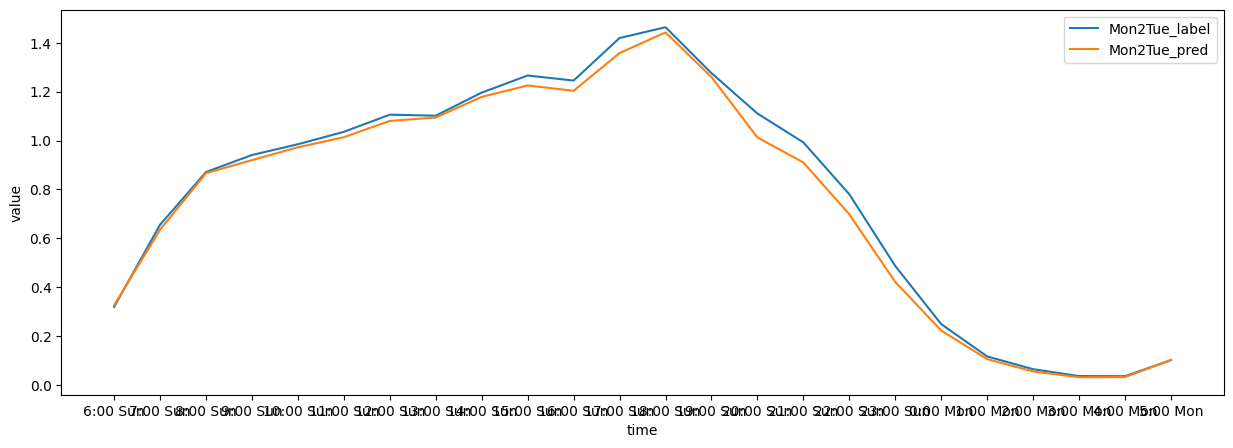

In [40]:
# -*- coding: UTF-8 -*-
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(x_label, y_time[0].cpu(), label='Mon2Tue_label')
plt.plot(x_label, p_time[0].cpu(), label='Mon2Tue_pred')
plt.legend()

plt.xlabel('time')
plt.ylabel('value')
plt.show()

In [28]:
x_label = ['6:00 Tue','7:00 Tue','8:00 Tue','9:00 Tue','10:00 Tue','11:00 Tue','12:00 Tue','13:00 Tue','14:00 Tue','15:00 Tue','16:00 Tue','17:00 Tue','18:00 Tue','19:00 Tue','20:00 Tue','21:00 Tue','22:00 Tue','23:00 Tue','0:00 Wed','1:00 Wed','2:00 Wed','3:00 Wed','4:00 Wed','5:00 Wed']

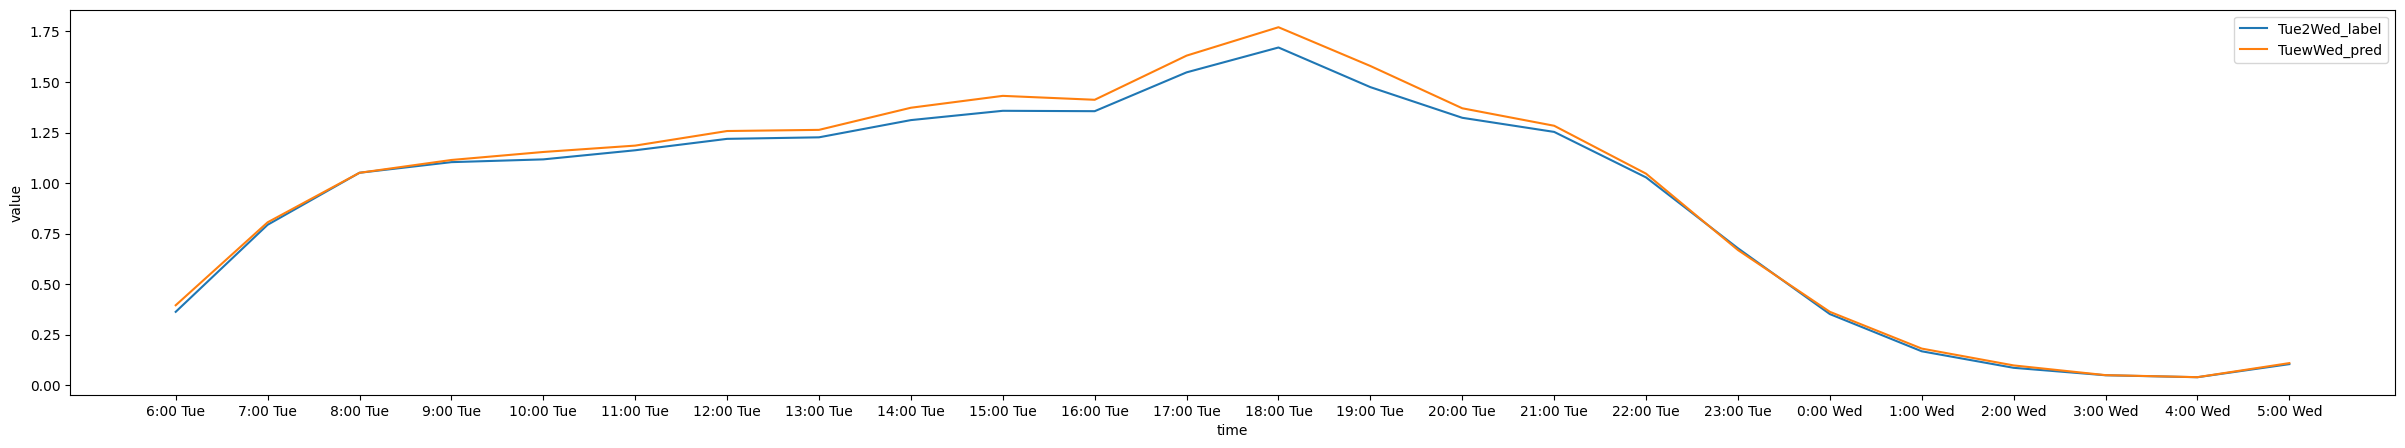

In [29]:
# -*- coding: UTF-8 -*-
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 5))
plt.plot(x_label, y_time[1].cpu(), label='Tue2Wed_label')
plt.plot(x_label, p_time[1].cpu(), label='TuewWed_pred')
plt.legend()

plt.xlabel('time')
plt.ylabel('value')
plt.show()

In [30]:
x_label = ['6:00 Wed','7:00 Wed','8:00 Wed','9:00 Wed','10:00 Wed','11:00 Wed','12:00 Wed','13:00 Wed','14:00 Wed','15:00 Wed','16:00 Wed','17:00 Wed','18:00 Wed','19:00 Wed','20:00 Wed','21:00 Wed','22:00 Wed','23:00 Wed','0:00 Thu','1:00 Thu','2:00 Thu','3:00 Thu','4:00 Thu','5:00 Thu']

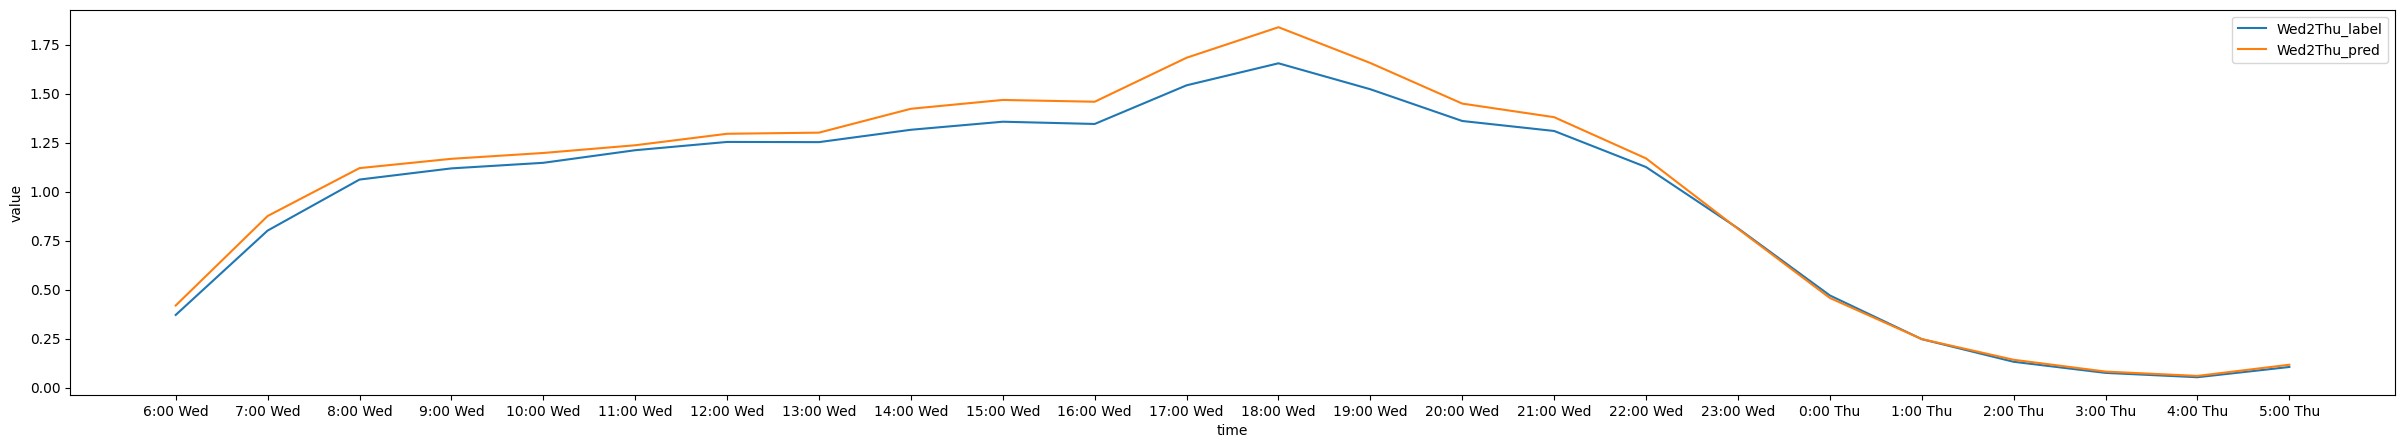

In [31]:
# -*- coding: UTF-8 -*-
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 5))
plt.plot(x_label, y_time[2].cpu(), label='Wed2Thu_label')
plt.plot(x_label, p_time[2].cpu(), label='Wed2Thu_pred')
plt.legend()

plt.xlabel('time')
plt.ylabel('value')
plt.show()

In [32]:
x_label = ['6:00 Thu','7:00 Thu','8:00 Thu','9:00 Thu','10:00 Thu','11:00 Thu','12:00 Thu','13:00 Thu','14:00 Thu','15:00 Thu','16:00 Thu','17:00 Thu','18:00 Thu','19:00 Thu','20:00 Thu','21:00 Thu','22:00 Thu','23:00 Thu','0:00 Fri','1:00 Fri','2:00 Fri','3:00 Fri','4:00 Fri','5:00 Fri']

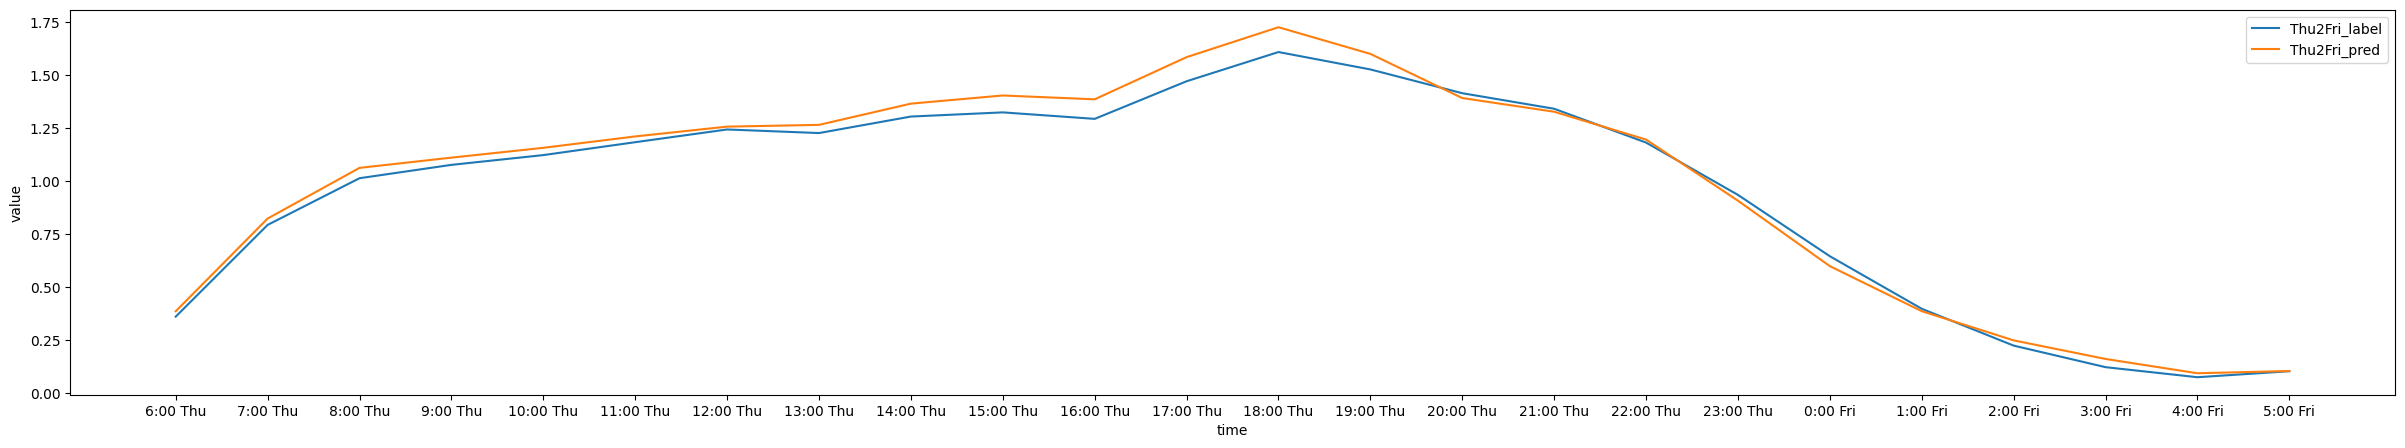

In [33]:
# -*- coding: UTF-8 -*-
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 5))
plt.plot(x_label, y_time[3].cpu(), label='Thu2Fri_label')
plt.plot(x_label, p_time[3].cpu(), label='Thu2Fri_pred')
plt.legend()

plt.xlabel('time')
plt.ylabel('value')
plt.show()

In [34]:
x_label = ['6:00 Fri','7:00 Fri','8:00 Fri','9:00 Fri','10:00 Fri','11:00 Fri','12:00 Fri','13:00 Fri','14:00 Fri','15:00 Fri','16:00 Fri','17:00 Fri','18:00 Fri','19:00 Fri','20:00 Fri','21:00 Fri','22:00 Fri','23:00 Fri','0:00 Sat','1:00 Sat','2:00 Sat','3:00 Sat','4:00 Sat','5:00 Sat']

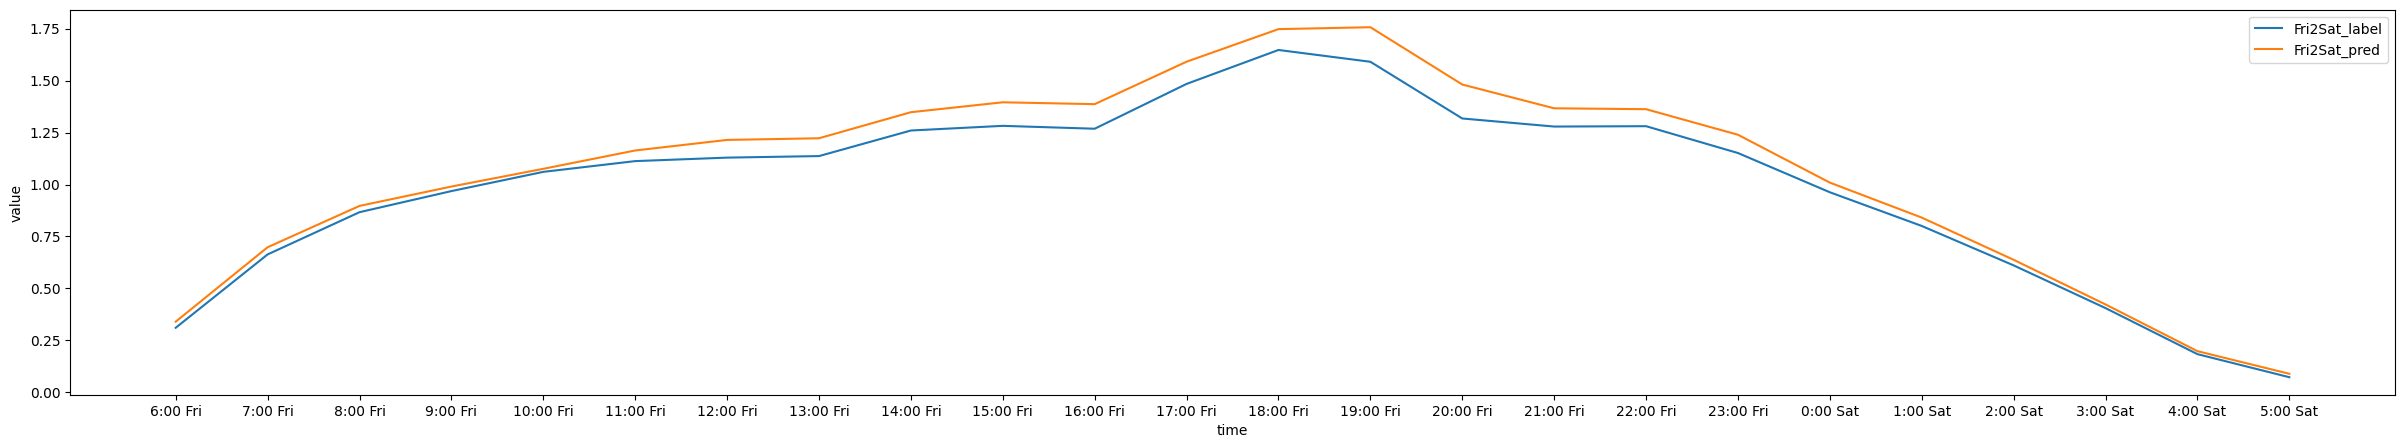

In [35]:
# -*- coding: UTF-8 -*-
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 5))
plt.plot(x_label, y_time[4].cpu(), label='Fri2Sat_label')
plt.plot(x_label, p_time[4].cpu(), label='Fri2Sat_pred')
plt.legend()

plt.xlabel('time')
plt.ylabel('value')
plt.show()

In [36]:
x_label = ['6:00 Sat','7:00 Sat','8:00 Sat','9:00 Sat','10:00 Sat','11:00 Sat','12:00 Sat','13:00 Sat','14:00 Sat','15:00 Sat','16:00 Sat','17:00 Sat','18:00 Sat','19:00 Sat','20:00 Sat','21:00 Sat','22:00 Sat','23:00 Sat','0:00 Sun','1:00 Sun','2:00 Sun','3:00 Sun','4:00 Sun','5:00 Sun']

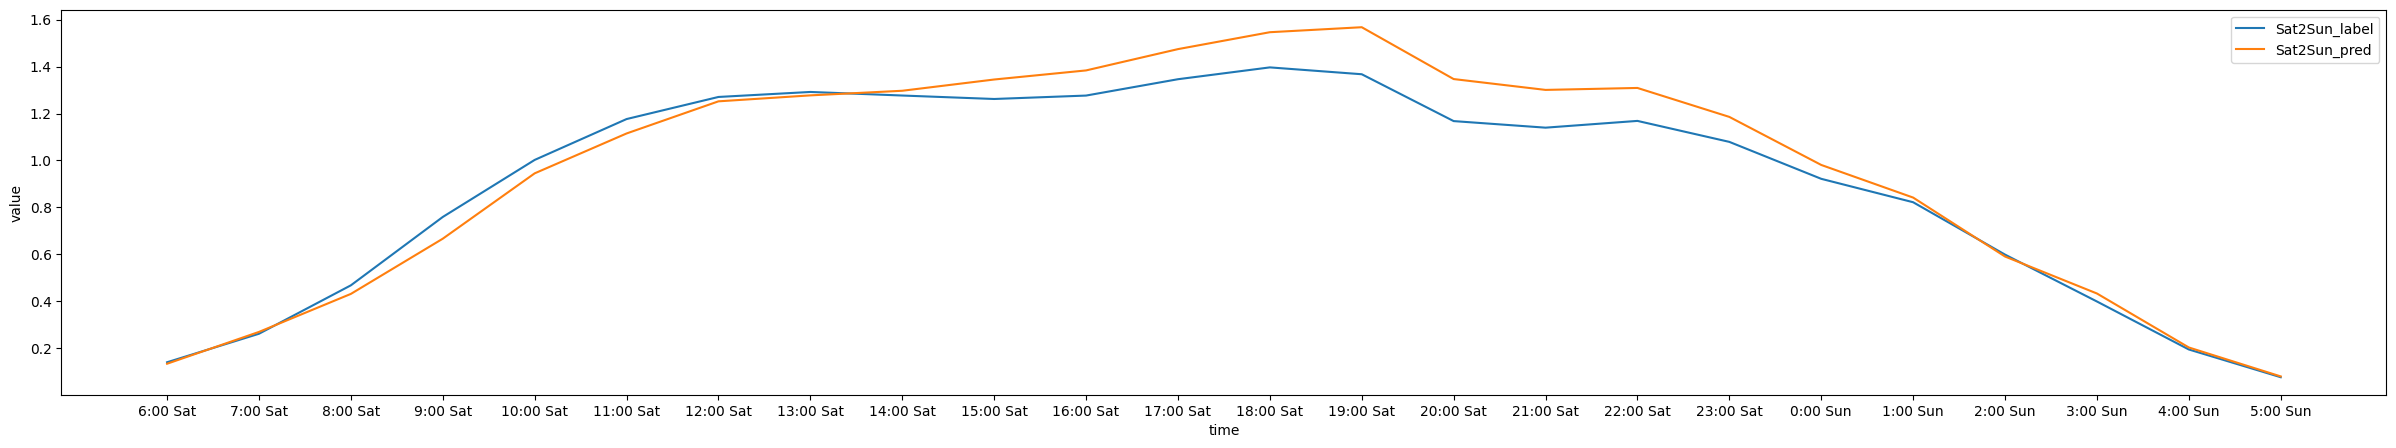

In [37]:
# -*- coding: UTF-8 -*-
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 5))
plt.plot(x_label, y_time[5].cpu(), label='Sat2Sun_label')
plt.plot(x_label, p_time[5].cpu(), label='Sat2Sun_pred')
plt.legend()

plt.xlabel('time')
plt.ylabel('value')
plt.show()

In [38]:
x_label = ['6:00 Sun','7:00 Sun','8:00 Sun','9:00 Sun','10:00 Sun','11:00 Sun','12:00 Sun','13:00 Sun','14:00 Sun','15:00 Sun','16:00 Sun','17:00 Sun','18:00 Sun','19:00 Sun','20:00 Sun','21:00 Sun','22:00 Sun','23:00 Sun','0:00 Mon','1:00 Mon','2:00 Mon','3:00 Mon','4:00 Mon','5:00 Mon']

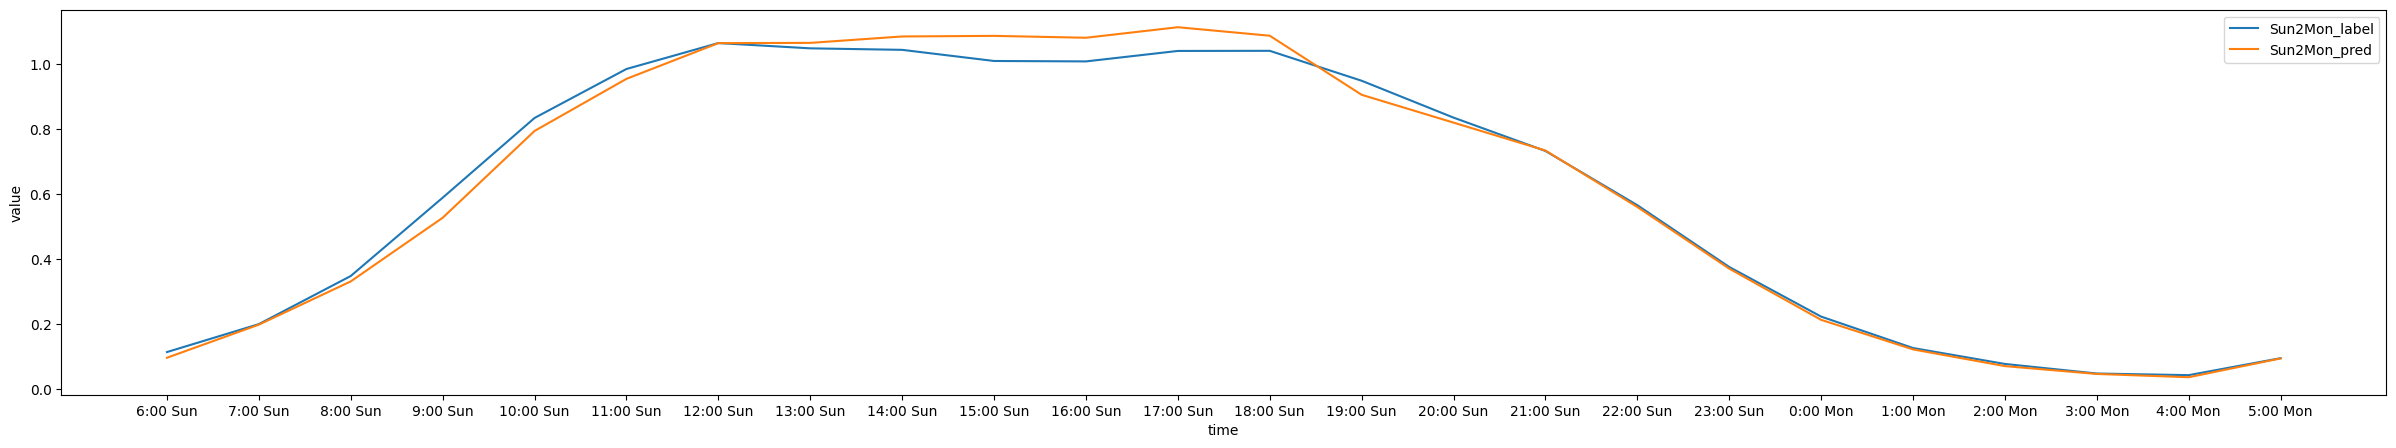

In [39]:
# -*- coding: UTF-8 -*-
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 5))
plt.plot(x_label, y_time[6].cpu(), label='Sun2Mon_label')
plt.plot(x_label, p_time[6].cpu(), label='Sun2Mon_pred')
plt.legend()

plt.xlabel('time')
plt.ylabel('value')
plt.show()

In [ ]:
# -*- coding: UTF-8 -*-
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(6,30), y_time[0].cpu(), label='Mon')
plt.plot(range(6,30), y_time[1].cpu(), label='Tue')
plt.plot(range(6,30), y_time[2].cpu(), label='Wed')
plt.plot(range(6,30), y_time[3].cpu(), label='Thu')
plt.plot(range(6,30), y_time[4].cpu(), label='Fri')
plt.plot(range(6,30), y_time[5].cpu(), label='Sat')
plt.plot(range(6,30), y_time[6].cpu(), label='Sun')
plt.legend()

plt.xlabel('time')
plt.ylabel('value')
plt.show()

In [ ]:
# -*- coding: UTF-8 -*-
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(6,30), p_time[0].cpu(), label='Mon')
plt.plot(range(6,30), p_time[1].cpu(), label='Tue')
plt.plot(range(6,30), p_time[2].cpu(), label='Wed')
plt.plot(range(6,30), p_time[3].cpu(), label='Thu')
plt.plot(range(6,30), p_time[4].cpu(), label='Fri')
plt.plot(range(6,30), p_time[5].cpu(), label='Sat')
plt.plot(range(6,30), p_time[6].cpu(), label='Sun')
plt.legend()

plt.xlabel('time')
plt.ylabel('value')
plt.show()

In [ ]:
y_weekday = y_total[:126]
y_weekday = y_weekday.reshape(18,7,24,66,66)
y_weekday = y_weekday[:,[3,4,5,6,0,1,2],:,:,:]
y_weekend = y_weekday[:,4:,:,:,:]
y_weekday = y_weekday[:,:4,:,:,:]
p_weekday = p_total[:126]
p_weekday = p_weekday.reshape(18,7,24,66,66)
p_weekday = p_weekday[:,[3,4,5,6,0,1,2],:,:,:]
p_weekend = p_weekday[:,4:,:,:,:]
p_weekday = p_weekday[:,:4,:,:,:]


In [ ]:
weekday_mse = masked_mse(y_weekday,p_weekday)
weekday_mse

In [ ]:
weekend_mse = masked_mse(y_weekend,p_weekend)
weekend_mse

In [ ]:
torch.where(y_total>1)

In [ ]:
torch.where(p_total>1)

In [ ]:
p_total[0][0].shape

In [ ]:
import torch
import matplotlib.pyplot as plt

# 创建两个示例的二维张量
data1 = torch.rand((10, 10))
data2 = torch.rand((10, 10))

# 创建一个包含两个子图的图形
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# 在第一个子图中绘制热力图
axs[0].imshow(y_total[0][0].cpu(), cmap='hot', interpolation='nearest')
axs[0].set_title('Actual OD')
axs[0].axis('off')  # 关闭坐标轴

# 在第二个子图中绘制热力图
axs[1].imshow(p_total[0][0].cpu(), cmap='hot', interpolation='nearest')
axs[1].set_title('Predicted OD')
axs[1].axis('off')  # 关闭坐标轴

plt.show()



In [ ]:
import torch
import matplotlib.pyplot as plt

# 创建两个示例的二维张量
data1 = torch.rand((10, 10))
data2 = torch.rand((10, 10))

# 创建一个包含两个子图的图形
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# 在第一个子图中绘制热力图
axs[0].imshow(y_total[0][1].cpu(), cmap='hot', interpolation='nearest')
axs[0].set_title('Actual OD')
axs[0].axis('off')  # 关闭坐标轴

# 在第二个子图中绘制热力图
axs[1].imshow(p_total[0][1].cpu(), cmap='hot', interpolation='nearest')
axs[1].set_title('Predicted OD')
axs[1].axis('off')  # 关闭坐标轴

plt.show()



In [ ]:
import torch
import matplotlib.pyplot as plt

# 创建两个示例的二维张量
data1 = torch.rand((10, 10))
data2 = torch.rand((10, 10))

# 创建一个包含两个子图的图形
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# 在第一个子图中绘制热力图
axs[0].imshow(y_total[0][2].cpu(), cmap='hot', interpolation='nearest')
axs[0].set_title('Actual OD')
axs[0].axis('off')  # 关闭坐标轴

# 在第二个子图中绘制热力图
axs[1].imshow(p_total[0][2].cpu(), cmap='hot', interpolation='nearest')
axs[1].set_title('Predicted OD')
axs[1].axis('off')  # 关闭坐标轴

plt.show()

